## Define the Agent state

In [1]:
"""
Portfolio Assistant with LangGraph - AI Agents System with Tool Routing
======================================================================

This notebook implements a LangGraph-based AI agents system with:
- Agent Node: Analyzes user input and decides when to use tools
- Tool Node: Contains all MCP tools and executes them automatically
- Conditional Routing: Routes between agent and tools based on AI decisions

The system connects to the MCP server and uses langchain-mcp-adapters for native integration.
"""

from typing import TypedDict, Annotated

from langgraph.graph.message import add_messages
from langchain_core.messages import AnyMessage

# State management
class AgentState(TypedDict):
    """State shared between all nodes in the workflow"""
    messages: Annotated[list[AnyMessage], add_messages]
    original_user_input: str
    execution_plan: AnyMessage


## Define tools
- Tools from MCP server (persistence)
- Custom tools
- Pre-built tools

### MCP tools

In [2]:
from langchain_mcp_adapters.client import MultiServerMCPClient

mcp_client = MultiServerMCPClient({
    "portfolio": {
        "url": "http://localhost:8081/mcp",
        "transport": "streamable_http",
    }
})

# Get tools from MCP server - this returns actual LangChain tools!
print("🔍 Connecting to MCP server and loading tools...")
try:
    available_tools = await mcp_client.get_tools()
    print(f"✅ Successfully loaded {len(available_tools)} LangChain tools from MCP server!")
    
    print("\n📊 Available Portfolio Tools:")
    for i, tool in enumerate(available_tools, 1):
        print(f"  {i:2d}. {tool.name}: {tool.description}")
    
    print(f"\n🎯 All tools are ready for LangGraph workflow!")
    
except Exception as e:
    print(f"❌ Failed to connect to MCP server: {e}")
    print("⚠️  Please ensure the MCP server is running on localhost:8081")
    print("   Command: python start_portfolio_http_server.py")
    available_tools = []


🔍 Connecting to MCP server and loading tools...
✅ Successfully loaded 12 LangChain tools from MCP server!

📊 Available Portfolio Tools:
   1. createTransaction: Create a new transaction in the portfolio.
   2. deleteTransaction: Delete a transaction by ID.
   3. getAllPositions: Get all current positions in the portfolio.
   4. getPortfolioSummary: Get portfolio summary with key metrics.
   5. getPositionByTicker: Get position details for a specific ticker.
   6. getTransaction: Get a transaction by its ID.
   7. getTransactionsByTicker: Get all transactions for a specific ticker.
   8. recalculateAllPositions: Recalculate all positions from transactions.
   9. recalculatePosition: Recalculate position for a specific ticker.
  10. searchTransactions: Search transactions with multiple filters.
  11. updateMarketData: Update market data for a position.
  12. updateTransaction: Update an existing transaction.

🎯 All tools are ready for LangGraph workflow!


### Custom tools for market analysis

In [3]:
from langchain_core.tools import tool
import yfinance as yf
from typing import Dict, Any

@tool
def get_stock_information(symbol: str) -> Dict[str, Any]:
    """ Get current stock price and basic information for a symbol """
    try:
        stock = yf.Ticker(symbol)
        info = stock.info
        hist = stock.history(period="1d")

        if hist.empty:
            return {"error": f"No data available for this symbol {symbol}"}

        current_price = hist["Close"].iloc[-1]
        return {
            "symbol": symbol,
            "current_price": current_price,
            "previous_close": float(info.get("previousClose", current_price)),
            "volume": info.get('volume', 0),
            "market_cap": info.get('marketCap'),
            "day_change": float(current_price - info.get('previousClose', current_price)),
            "day_change_percent": float(((current_price - info.get('previousClose', current_price)) / info.get('previousClose', current_price)) * 100) if info.get('previousClose') else 0
        }
    except Exception as e:
        return {"error": f"Error fetching stock info for {symbol}: {str(e)}"}


In [4]:
from langchain_core.tools import tool
from typing import Dict, Any

@tool 
def calculate_position_value(symbol: str, quantity: float, avg_cost: float, current_price: float) -> Dict[str, Any]:
    """Calculate the current value and P&L for a stock position"""
    market_value = quantity * current_price
    cost_basis = quantity * avg_cost
    gain_loss = market_value - cost_basis
    gain_loss_percent = (gain_loss / cost_basis) * 100 if cost_basis > 0 else 0
    
    return {
        "symbol": symbol,
        "market_value": market_value,
        "cost_basis": cost_basis,
        "gain_loss": gain_loss,
        "gain_loss_percent": gain_loss_percent,
        "current_price": current_price,
        "quantity": quantity,
        "avg_cost": avg_cost
    }

In [5]:

@tool
def detect_stock_splits(symbol: str, days_back: int = 720) -> Dict[str, Any]:
    """Detect stock splits for a symbol within specified days back"""
    try:
        stock = yf.Ticker(symbol)
        splits = stock.splits
        
        if splits.empty:
            return {"symbol": symbol, "splits_found": False, "splits": []}
        
        # Filter splits within the specified period
        from datetime import datetime, timedelta
        import pandas as pd
        cutoff_date = datetime.now() - timedelta(days=days_back)
        # Handle timezone awareness - convert to UTC if splits.index is timezone-aware
        if splits.index.tz is not None:
            cutoff_date = pd.Timestamp(cutoff_date).tz_localize('UTC')
        recent_splits = splits[splits.index >= cutoff_date]
        
        splits_data = []
        for split_date, split_ratio in recent_splits.items():
            splits_data.append({
                "date": split_date.strftime("%Y-%m-%d"),
                "ratio": float(split_ratio),
                "description": f"{int(split_ratio)}:1 split" if split_ratio >= 1 else f"1:{int(1/split_ratio)} reverse split"
            })
        
        return {
            "symbol": symbol,
            "splits_found": len(splits_data) > 0,
            "splits": splits_data,
            "total_splits": len(splits_data)
        }
    except Exception as e:
        return {"error": f"Error detecting splits for {symbol}: {str(e)}"}

In [6]:
@tool
def calculate_position_value_with_splits(
    symbol: str, 
    original_quantity: float, 
    original_avg_cost: float, 
    purchase_date: str = None
) -> Dict[str, Any]:
    """Calculate position value accounting for stock splits since purchase"""
    try:
        # Get current stock price
        stock_info = get_stock_information(symbol)
        if "error" in stock_info:
            return stock_info
        
        current_price = stock_info["current_price"]
        
        # Check for splits since purchase date
        if purchase_date:
            from datetime import datetime
            purchase_dt = datetime.strptime(purchase_date, "%Y-%m-%d")
            days_since_purchase = (datetime.now() - purchase_dt).days
            
            splits_info = detect_stock_splits(symbol, days_since_purchase)
            
            # Apply split adjustments
            adjusted_quantity = original_quantity
            adjusted_avg_cost = original_avg_cost
            
            if splits_info["splits_found"]:
                cumulative_split_ratio = 1.0
                for split in splits_info["splits"]:
                    split_date = datetime.strptime(split["date"], "%Y-%m-%d")
                    if split_date >= purchase_dt:
                        cumulative_split_ratio *= split["ratio"]
                
                adjusted_quantity = original_quantity * cumulative_split_ratio
                adjusted_avg_cost = original_avg_cost / cumulative_split_ratio
        else:
            adjusted_quantity = original_quantity
            adjusted_avg_cost = original_avg_cost
            splits_info = {"splits_found": False, "splits": []}
        
        # Calculate position metrics
        market_value = adjusted_quantity * current_price
        cost_basis = adjusted_quantity * adjusted_avg_cost
        gain_loss = market_value - cost_basis
        gain_loss_percent = (gain_loss / cost_basis) * 100 if cost_basis > 0 else 0
        
        return {
            "symbol": symbol,
            "original_quantity": original_quantity,
            "original_avg_cost": original_avg_cost,
            "current_quantity": adjusted_quantity,
            "current_avg_cost": adjusted_avg_cost,
            "current_price": current_price,
            "market_value": market_value,
            "cost_basis": cost_basis,
            "gain_loss": gain_loss,
            "gain_loss_percent": gain_loss_percent,
            "splits_applied": splits_info["splits"],
            "split_adjusted": splits_info["splits_found"]
        }
    except Exception as e:
        return {"error": f"Error calculating position for {symbol}: {str(e)}"}

In [7]:
@tool
def detect_fractional_share_offering(symbol: str, user_paid_price: float) -> Dict[str, Any]:
    """Detect if broker is offering fractional shares based on price discrepancy"""
    try:
        # Get actual market price
        stock_info = get_stock_information(symbol)
        if "error" in stock_info:
            return stock_info
        
        actual_price = stock_info["current_price"]
        price_ratio = actual_price / user_paid_price
        
        # Common fractional ratios
        common_ratios = [
            2, 3, 4, 5, 6, 8, 10, 12, 15, 16, 20, 25, 30, 32, 40, 50, 
            60, 64, 75, 80, 100, 120, 125, 150, 160, 200, 250, 300, 
            400, 500, 600, 750, 800, 1000, 1250, 1500, 2000
        ]
        
        # Find closest ratio
        closest_ratio = min(common_ratios, key=lambda x: abs(x - price_ratio))
        
        # Flexible tolerance - either 10% OR if ratio is > 1.5 (clear fractional indicator)
        tolerance_percentage = 0.15 if price_ratio > 1.5 else 0.05  # 15% for likely fractional, 5% for borderline
        is_fractional = (
            abs(price_ratio - closest_ratio) < (closest_ratio * tolerance_percentage) or 
            price_ratio > 1.5  # Any ratio > 1.5 is likely fractional
        )
        
        # If no close match found but ratio is high, try to find a reasonable approximation
        if not is_fractional and price_ratio > 1.5:
            # Round to nearest logical fraction
            if price_ratio < 10:
                closest_ratio = round(price_ratio)
            elif price_ratio < 100:
                closest_ratio = round(price_ratio / 5) * 5  # Round to nearest 5
            elif price_ratio < 1000:
                closest_ratio = round(price_ratio / 10) * 10  # Round to nearest 10
            else:
                closest_ratio = round(price_ratio / 50) * 50  # Round to nearest 50
            
            is_fractional = True
        
        return {
            "symbol": symbol,
            "actual_price": actual_price,
            "user_paid_price": user_paid_price,
            "calculated_ratio": price_ratio,
            "is_fractional_offering": is_fractional,
            "estimated_fraction": 1 / closest_ratio if is_fractional else 1,
            "estimated_ratio": f"1:{closest_ratio}" if is_fractional else "1:1",
            "actual_shares_owned": 1 / closest_ratio if is_fractional else 1,
            "explanation": f"You own {1/closest_ratio:.6f} shares of the actual stock" if is_fractional else "You own full shares",
            "confidence": "high" if abs(price_ratio - closest_ratio) < (closest_ratio * 0.05) else "medium"
        }
    except Exception as e:
        return {"error": f"Error analyzing fractional offering for {symbol}: {str(e)}"}

In [8]:
@tool
def calculate_fractional_position_value(
    symbol: str, 
    broker_quantity: float, 
    price_paid_per_unit: float
) -> Dict[str, Any]:
    """Calculate position value accounting for fractional share offerings"""
    try:
        # Detect if this is a fractional offering
        fractional_info = detect_fractional_share_offering(symbol, price_paid_per_unit)
        if "error" in fractional_info:
            return fractional_info
        
        # Get current market price
        stock_info = get_stock_information(symbol)
        if "error" in stock_info:
            return stock_info
        
        current_actual_price = stock_info["current_price"]
        
        if fractional_info["is_fractional_offering"]:
            # Calculate actual shares owned
            fraction_per_unit = fractional_info["estimated_fraction"]
            actual_shares_owned = broker_quantity * fraction_per_unit
            
            # Calculate values
            current_market_value = actual_shares_owned * current_actual_price
            cost_basis = broker_quantity * price_paid_per_unit
            gain_loss = current_market_value - cost_basis
            gain_loss_percent = (gain_loss / cost_basis) * 100 if cost_basis > 0 else 0
            
            return {
                "symbol": symbol,
                "is_fractional_offering": True,
                "broker_units_owned": broker_quantity,
                "actual_shares_owned": actual_shares_owned,
                "fraction_ratio": fractional_info["estimated_ratio"],
                "current_actual_share_price": current_actual_price,
                "price_paid_per_unit": price_paid_per_unit,
                "current_market_value": current_market_value,
                "cost_basis": cost_basis,
                "gain_loss": gain_loss,
                "gain_loss_percent": gain_loss_percent,
                "explanation": f"Your broker offers 1 unit = {fraction_per_unit:.4f} actual shares"
            }
        else:
            # Regular calculation
            return calculate_position_value(symbol, broker_quantity, price_paid_per_unit, current_actual_price)
            
    except Exception as e:
        return {"error": f"Error calculating fractional position for {symbol}: {str(e)}"}

### Prebuilt tool

In [9]:
from langchain_community.tools import TavilySearchResults
from langchain_community.tools import WikipediaQueryRun
from langchain_community.utilities import WikipediaAPIWrapper
from tools.youtube_video_transcript import YoutubeVideoTranscriptTool
from tools.image_analyzer import ImageAnalyzer
from tools.document_question_answering_tool import DocumentQuestionAnsweringTool
from tools.youtube_video_transcript import YoutubeVideoTranscriptTool

tavily_web_search = TavilySearchResults(max_results=3)
wikipedia = WikipediaQueryRun(api_wrapper=WikipediaAPIWrapper())
youtube_video_transcript = YoutubeVideoTranscriptTool()
image_analyzer = ImageAnalyzer()
document_question_answering = DocumentQuestionAnsweringTool()

In [10]:
available_tools.append(calculate_position_value)
available_tools.append(get_stock_information)
available_tools.append(calculate_position_value_with_splits)
available_tools.append(detect_stock_splits)
available_tools.append(detect_fractional_share_offering)
available_tools.append(calculate_fractional_position_value)
available_tools.append(tavily_web_search)
available_tools.append(wikipedia)
available_tools.append(youtube_video_transcript)
available_tools.append(image_analyzer)
available_tools.append(document_question_answering)
available_tools

[StructuredTool(name='createTransaction', description='Create a new transaction in the portfolio.', args_schema={'type': 'object', 'properties': {'ticker': {'type': 'string', 'description': 'Stock ticker symbol'}, 'type': {'type': 'string', 'description': 'Transaction type (BUY, SELL, DIVIDEND)'}, 'quantity': {'description': 'Quantity of shares'}, 'price': {'description': 'Price per share'}, 'fees': {'description': 'Fees paid per transaction'}, 'isFractional': {'type': 'boolean', 'description': 'Determine if this is an operation on a stock fraction (for fractional offerings)'}, 'fractionalMultiplier': {'description': 'Fraction of the real stock option represented by this fracitonal offered option'}, 'commissionCurrency': {'type': 'string', 'enum': ['USD', 'EUR', 'GBP', 'CAD', 'JPY'], 'description': 'Fees currency'}, 'currency': {'type': 'string', 'enum': ['USD', 'EUR', 'GBP', 'CAD', 'JPY'], 'description': 'Transaction currency'}, 'date': {'type': 'string', 'description': 'Transaction d

## Define the main LLM and bind tools

In [11]:
from langchain_openai import ChatOpenAI
from langchain_ollama import ChatOllama
from langchain_anthropic import ChatAnthropic
from langchain_core.rate_limiters import InMemoryRateLimiter
import os

rate_limiter = InMemoryRateLimiter(requests_per_second=2, check_every_n_seconds=0.2, max_bucket_size=5)

#llm = ChatOllama(model="qwen2.5:32b", num_ctx=32768)
#llm = ChatAnthropic(model="claude-3-5-haiku-latest", rate_limiter=rate_limiter)
llm = ChatOpenAI(model="gpt-4.1", rate_limiter=rate_limiter)
llm_with_tools = llm.bind_tools(available_tools)

# Planner node

In [12]:
from langchain_core.messages import SystemMessage

#planner_llm = ChatOllama(model="qwen2.5:32b", num_ctx=32768)
#planner_llm = ChatAnthropic(model="claude-3-5-haiku-latest")
planner_llm = ChatOpenAI(model="gpt-4o")

tool_descriptions = []
for tool in available_tools:
    name = tool.name
    desc = tool.description
    tool_descriptions.append(f"- {name}: {desc}")

tools_list_text = "\n".join(tool_descriptions)

def planner(state: AgentState):
    print("\n----- Running planner -----\n")
    original_input = state.get("original_user_input", "")

    system_prompt = (
        f"""
        You are a strategic planning agent for a comprehensive portfolio management system. Your role is to analyze user requests and create detailed, step-by-step execution plans to accomplish their goals. You have knowledge of all available tools but CANNOT execute them directly - you only create plans for other agents to follow.
        Available Tools in the System:
        {tools_list_text}

        ## Your Planning Process
        For each user request, follow this structured approach:

        1. **REQUEST ANALYSIS**: 
        - Identify the user's primary goal
        - Determine required data inputs
        - Identify potential risks or edge cases

        2. **STEP-BY-STEP PLAN**:
        - Break down the request into logical, sequential steps
        - Specify which tool should be used for each step
        - Include necessary parameters and data flow between steps
        - Consider error handling and validation points

        3. **DEPENDENCIES & PREREQUISITES**:
        - Identify what data must be gathered first
        - Note any required validations or checks
        - Specify parallel vs sequential execution requirements

        4. **SUCCESS CRITERIA**:
        - Define what constitutes successful completion
        - Specify expected outputs or outcomes
        - Include verification steps

        ## Planning Guidelines

        - **Be Specific**: Name exact tools and parameters needed
        - **Consider Data Flow**: Ensure outputs from one step feed properly into the next
        - **Include Validation**: Plan for data verification and error checking
        - **Think Holistically**: Consider portfolio impact, not just individual transactions
        - **Plan for Errors**: Include fallback strategies and rollback procedures
        - **Optimize Efficiency**: Suggest parallel execution where appropriate
        """
    )

    user_prompt = f"User request: {original_input}"

    try:
        plan_message = planner_llm.invoke([
            {"role": "system", "content": system_prompt},
            {"role": "user", "content": user_prompt}
        ])
    except Exception as e:
        print(f"Error calling to planner LLM: {e}")
        return {
            "original_user_input": original_input,
            "messages": state['messages'],
            "execution_plan": state['execution_plan']
        }

    plan_user_message = HumanMessage(content=f"Execution Plan:\n{plan_message.content}")

    # Combine with existing messages properly
    existing_messages = state.get('messages', [])
    updated_messages = existing_messages + [plan_user_message]

    return {
        "original_user_input": original_input,
        "messages": updated_messages,
        "execution_plan": plan_message
    }

## Assistant node

In [13]:
from langchain_core.messages import SystemMessage, HumanMessage, AIMessage

def sanitize_messages_for_anthropic(messages):
    """
    Sanitize messages for Anthropic API requirements:
    - Only one system message at the beginning
    - Convert additional system messages to user messages
    - Ensure proper message ordering
    """
    if not messages:
        return messages
    
    # Separate system and non-system messages
    system_messages = []
    other_messages = []
    
    for msg in messages:
        if isinstance(msg, SystemMessage):
            system_messages.append(msg)
        else:
            other_messages.append(msg)
    
    # Combine all system content into one system message
    if system_messages:
        combined_system_content = "\n\n".join([msg.content for msg in system_messages])
        # Only keep the first system message with combined content
        sanitized_messages = [SystemMessage(content=combined_system_content)]
        sanitized_messages.extend(other_messages)
    else:
        sanitized_messages = other_messages
    
    return sanitized_messages

print("✅ Anthropic message sanitization helper loaded")


✅ Anthropic message sanitization helper loaded


In [14]:
from langchain_core.messages import SystemMessage

def assistant(state: AgentState):
    print("\n\n\n ----- Running assistant... ----- \n\n\n")
    try:
        sanitized_messages = sanitize_messages_for_anthropic(state['messages'])
        response = llm_with_tools.invoke(sanitized_messages)
    except Exception as e:
        print(f"Error calling to assistant LLM with tools: {e}")
        return {
            "original_user_input": state["original_user_input"],
            "messages": state['messages'],
            "execution_plan": state['execution_plan']
        }

    print(f"State: {response}")
    
    return {
        "original_user_input": state["original_user_input"],
        "messages": state['messages'] + [response],
        "execution_plan": state['execution_plan']
    }

## Build the graph

In [15]:
from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import ToolNode, tools_condition
from langgraph.checkpoint.memory import MemorySaver

graph_builder = StateGraph(AgentState)

tools_node = ToolNode(available_tools)
graph_builder.add_node("planner", planner)
graph_builder.add_node("assistant", assistant)
graph_builder.add_node("tools", tools_node)

graph_builder.add_edge(START, "planner")
graph_builder.add_edge("planner", "assistant")
graph_builder.add_conditional_edges("assistant", tools_condition)
graph_builder.add_edge("tools", "assistant")

memory = MemorySaver()
graph = graph_builder.compile(checkpointer=memory)

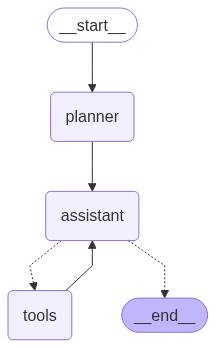

In [16]:
from IPython.display import Image, display

display(Image(graph.get_graph(xray=True).draw_mermaid_png(max_retries=5, retry_delay=3.0)))

## Gradio Integration - Portfolio Assistant Chatbot


In [17]:
import gradio as gr
from langchain_core.messages import HumanMessage, AIMessage, SystemMessage
import uuid
import asyncio
from datetime import datetime

# System prompt for the Portfolio Assistant
SYSTEM_PROMPT = """
You are a Portfolio Assistant AI that helps users manage and analyze their investment portfolio. 
You have access to a comprehensive set of portfolio management tools that allow you to:

📊 **Portfolio Analysis:**
- View all current positions and portfolio summary
- Get performance metrics and analytics
- Analyze specific ticker investments

💼 **Transaction Management:**
- Create, update, and delete transactions
- Search transactions by various criteria
- View transaction history for specific tickers

💰 **Position Management:**
- Get detailed position information
- Update market data and current prices
- Recalculate positions when needed

🔍 **Data & Insights:**
- Search and filter portfolio data
- Get comprehensive ticker analysis
- Monitor portfolio performance over time
- Detect stock splits, if any position shows a big difference in cost per share compared to the current market price (e.g. more than 100% difference), be suspicious and ask the user to check the splits
- Detect if broker is offering fractional shares based on price discrepancy when market price is much higher than the user paid price (e.g. more than 100% difference)
"""

# Global variable to store the current thread_id for debugging
current_thread_id = None

def format_message_for_debug(msg, index):
    """Format a single message for readable display"""
    msg_type = type(msg).__name__
    timestamp = datetime.now().strftime("%H:%M:%S")
    
    if hasattr(msg, 'content'):
        content = msg.content
    else:
        content = str(msg)
    
    # Handle tool calls if present
    tool_info = ""
    if hasattr(msg, 'tool_calls') and msg.tool_calls:
        tool_info = f"\n   🔧 Tool Calls: {[tc.get('name', 'Unknown') for tc in msg.tool_calls]}"
    
    return f"""
┌─ Message {index + 1}: {msg_type} [{timestamp}]
│  📝 Content: {content}
│  🏷️  Additional: {getattr(msg, 'additional_kwargs', {})}{tool_info}
└─ """

async def get_graph_memory_debug_async(thread_id_input=None):
    """Retrieve and format all messages from graph memory for debugging (async version)"""
    try:
        # Use provided thread_id or current one
        debug_thread_id = thread_id_input.strip() if thread_id_input else current_thread_id
        
        if not debug_thread_id:
            return "❌ No thread ID available. Start a conversation first or provide a thread ID."
        
        # Get state from graph memory
        config = {"configurable": {"thread_id": debug_thread_id}}
        
        try:
            state = await graph.aget_state(config)  # Use async version
            
            if not state or not state.values:
                return f"📭 No state found for thread ID: {debug_thread_id}"
            
            messages = state.values.get("messages", [])
            original_input = state.values.get("original_user_input", "N/A")
            execution_plan = state.values.get("execution_plan", "N/A")
            
            # Format output
            debug_output = f"""
🔍 LANGGRAPH MEMORY DEBUG
═══════════════════════════════════════════════════════════════

🆔 Thread ID: {debug_thread_id}
📋 Original Input: {original_input}
💬 Total Messages: {len(messages)}
📝 Execution Plan: {type(execution_plan).__name__ if execution_plan else "None"}

📨 MESSAGE HISTORY:
═══════════════════════════════════════════════════════════════
"""
            
            if messages:
                for i, msg in enumerate(messages):
                    debug_output += format_message_for_debug(msg, i)
            else:
                debug_output += "\n📭 No messages found in memory."
            
            debug_output += f"""
═══════════════════════════════════════════════════════════════

🔧 GRAPH STATE SUMMARY:
- State Keys: {list(state.values.keys()) if state.values else "None"}
- Next Node: {state.next or "END"}
- Config: {state.config}

🕒 Last Updated: {datetime.now().strftime("%Y-%m-%d %H:%M:%S")}
═══════════════════════════════════════════════════════════════
"""
            
            return debug_output
            
        except Exception as e:
            return f"❌ Error accessing graph state: {str(e)}"
            
    except Exception as e:
        return f"❌ Debug error: {str(e)}"

def get_graph_memory_debug(thread_id_input=None):
    """Sync wrapper for the async debug function"""
    try:
        # Create new event loop for this sync function
        loop = asyncio.new_event_loop()
        asyncio.set_event_loop(loop)
        try:
            return loop.run_until_complete(get_graph_memory_debug_async(thread_id_input))
        finally:
            loop.close()
    except Exception as e:
        return f"❌ Debug error: {str(e)}"

def reset_conversation():
    """Reset the conversation thread and clear chat UI"""
    global current_thread_id
    old_thread_id = current_thread_id
    current_thread_id = str(uuid.uuid4())
    
    status_message = f"""🔄 Conversation Reset Complete!

📋 Details:
• Previous Thread ID: {old_thread_id or 'None'}
• New Thread ID: {current_thread_id}
• Chat history cleared
• Fresh conversation started

💡 You can now start a new conversation with a clean slate!"""
    
    return status_message, None  # Return status and None to clear chat

async def chat_with_portfolio_assistant(message, history):
    """
    Handle chat interaction with the Portfolio Assistant (SIMPLIFIED VERSION)
    """
    global current_thread_id
    
    try:
        # Use persistent thread ID for the conversation
        if current_thread_id is None:
            current_thread_id = str(uuid.uuid4())
        
        config = {"configurable": {"thread_id": current_thread_id}}
        
        messages = [
            SystemMessage(content=SYSTEM_PROMPT),
            HumanMessage(content=message)
        ]
        
        # Prepare initial state
        initial_state = {
            "messages": messages,
            "original_user_input": message,
            "execution_plan": ""
        }
        
        # Use ASYNC invocation for MCP tools compatibility
        print(f"🔄 Processing request: {message[:50]}...")
        print(f"🆔 Thread ID: {current_thread_id}")
        
        # Use ainvoke for async tools
        final_state = await graph.ainvoke(initial_state, config=config)
        
        # Extract the assistant's response
        response_content = ""
        if final_state.get("messages"):
            # Find the last AI message
            for msg in reversed(final_state["messages"]):
                if hasattr(msg, 'content') and isinstance(msg, AIMessage):
                    response_content = clean_llm_response(msg.content)
                    break
        
        if not response_content:
            return "I apologize, but I encountered an issue processing your request. Please try again."
        
        print(f"✅ Response ready ({len(response_content)} chars)")
        return response_content
        
    except Exception as e:
        print(f"❌ Error in chat function: {e}")
        import traceback
        traceback.print_exc()
        return f"I encountered an error: {str(e)}. Please try your request again."

import re

def clean_llm_response(response: str) -> str:
    """Remove thinking sections that break Gradio display"""
    
    # Remove common thinking section patterns
    patterns = [
        r'<thinking>.*?</thinking>',
        r'<think>.*?</think>',
        r'<thought>.*?</thought>', 
        r'<reasoning>.*?</reasoning>',
        r'\[thinking\].*?\[/thinking\]',
        r'<!--.*?thinking.*?-->'
    ]
    
    cleaned = response
    for pattern in patterns:
        cleaned = re.sub(pattern, '', cleaned, flags=re.DOTALL | re.IGNORECASE)
    
    # Clean up extra whitespace
    cleaned = re.sub(r'\n\s*\n\s*\n', '\n\n', cleaned)
    cleaned = cleaned.strip()
    
    # Return fallback if empty
    return cleaned if cleaned else "Response processed successfully."

# Create Gradio interface
def create_portfolio_chatbot():
    """
    Create and configure the Gradio chatbot interface with debug functionality
    """
    
    with gr.Blocks(
        title="Portfolio Assistant", 
        theme=gr.themes.Soft(),
        css="""
        .gradio-container {
            max-width: 1400px !important;
        }
        .chat-message {
            border-radius: 10px !important;
        }
        .debug-section {
            border: 2px solid #e1e5e9;
            border-radius: 8px;
            padding: 10px;
            margin: 10px 0;
        }
        """
    ) as interface:
        
        gr.Markdown(
            """
            # 📈 Portfolio Assistant
            
            Welcome to your AI-powered Portfolio Assistant! I can help you manage and analyze your investment portfolio using advanced tools and real-time data.
            
            **What I can help you with:**
            - 📊 Portfolio analysis and performance metrics
            - 💼 Transaction management (create, update, delete)
            - 💰 Position tracking and market data updates
            - 🔍 Advanced search and filtering
            - 📈 Investment insights and recommendations
            
            **💬 Chat with your Portfolio Assistant below:**
            Ask me anything about your portfolio - I have access to all your investment data!
            """
        )
        
        # Main chat interface
        chatbot_interface = gr.ChatInterface(
            fn=chat_with_portfolio_assistant,
            examples=[
                "What's my current portfolio summary?",
                "Show me all my transactions for AAPL",
                "Add a buy transaction: 50 shares of MSFT at $350 on 2024-01-15",
                "What are my performance metrics?",
                "Update Tesla's current price to $245",
                "What's my position in Apple stock?",
                "Search for all transactions in the last 30 days"
            ],
            type="messages"
        )
        
        # Debug section
        gr.Markdown("---")
        gr.Markdown("## 🔍 Debug & Control Tools", elem_classes=["debug-section"])
        
        with gr.Row():
            with gr.Column(scale=2):
                thread_id_input = gr.Textbox(
                    label="🆔 Thread ID (optional)",
                    placeholder="Leave empty to use current conversation thread",
                    info="Enter a specific thread ID to debug, or leave empty to debug current conversation"
                )
            
            with gr.Column(scale=1):
                with gr.Row():
                    debug_btn = gr.Button("🔍 View Memory", variant="secondary")
                    reset_btn = gr.Button("🔄 Reset Conversation", variant="stop")
        
        # Status output for reset
        reset_status = gr.Textbox(
            label="🔄 Reset Status",
            placeholder="Click 'Reset Conversation' to start fresh...",
            lines=6,
            show_copy_button=False,
            elem_classes=["debug-section"]
        )
        
        # Debug output area
        debug_output = gr.Textbox(
            label="📋 Graph Memory Debug Output",
            placeholder="Click 'View Memory' to see the current graph state and message history...",
            lines=20,
            max_lines=30,
            show_copy_button=True,
            elem_classes=["debug-section"]
        )
        
        # Current thread ID display
        current_thread_display = gr.Textbox(
            label="🆔 Current Thread ID",
            value=lambda: current_thread_id or "No active conversation",
            interactive=False
        )
        
        # Wire up the functionality
        debug_btn.click(
            fn=get_graph_memory_debug,
            inputs=[thread_id_input],
            outputs=[debug_output]
        )
        
        # ✅ FIXED: Reset conversation properly
        reset_btn.click(
            fn=reset_conversation,
            inputs=[],
            outputs=[reset_status, chatbot_interface.chatbot]  # Clear both status and chat
        ).then(
            fn=lambda: current_thread_id or "No active conversation",
            inputs=[],
            outputs=[current_thread_display]  # Update thread ID display
        )
        
        # Add footer information
        gr.Markdown(
            """
            ---
            
            **💡 Tips:**
            - Be specific when adding transactions (include ticker, quantity, price, date)
            - Ask for summaries to get quick overviews
            - Use ticker symbols (e.g., AAPL, MSFT, TSLA) for best results
            - I can handle multiple requests in one message
            
            **🔧 Tools Available:** Transaction Management, Portfolio Analysis, Position Tracking, Performance Metrics, Market Data Updates
            
            **🔍 Debug & Control Tools:**
            - **View Memory**: See all messages and state in the current conversation thread
            - **Reset Conversation**: Clear chat history and start with a new thread ID
            - **Thread ID**: Each conversation gets a unique ID for memory isolation
            """
        )
    
    return interface

# Create and launch the chatbot
print("🚀 Setting up Portfolio Assistant Chatbot with Reset Functionality...")
portfolio_chatbot = create_portfolio_chatbot()

print("✅ Portfolio Assistant is ready!")
print("📝 The chatbot interface has been created and is ready to launch.")
print("💡 Features included:")
print("   - 💬 Full conversation interface")
print("   - 🔍 Memory debugging tools")
print("   - 🆔 Thread ID tracking")
print("   - 📋 Message history viewer")
print("   - ⚡ Async tool support for MCP")
print("   - 🔄 Working reset conversation functionality")
print("💡 Run portfolio_chatbot.launch() to start the interface!")

🚀 Setting up Portfolio Assistant Chatbot with Reset Functionality...
✅ Portfolio Assistant is ready!
📝 The chatbot interface has been created and is ready to launch.
💡 Features included:
   - 💬 Full conversation interface
   - 🔍 Memory debugging tools
   - 🆔 Thread ID tracking
   - 📋 Message history viewer
   - ⚡ Async tool support for MCP
   - 🔄 Working reset conversation functionality
💡 Run portfolio_chatbot.launch() to start the interface!


In [18]:
# Launch the Portfolio Assistant Chatbot
if __name__ == "__main__":
    print("🎯 Starting Portfolio Assistant Chatbot...")
    print("🔗 Make sure your MCP server is running on localhost:8081")
    print("📡 Launching Gradio interface...")
    
    # Launch with share=False for local use, set share=True to create public link
    portfolio_chatbot.launch(
        server_name="127.0.0.1",  # Local access only
        server_port=7860,         # Default Gradio port
        share=False,              # Set to True for public sharing
        debug=True,               # Enable debug mode
        show_error=True,          # Show detailed error messages
        quiet=False,              # Show startup logs
        inbrowser=True,           # Auto-open in browser
        height=800,               # Interface height
        favicon_path=None,        # You can add a custom favicon
        auth=None,                # Add authentication if needed: auth=("username", "password")
    )
else:
    print("📝 To launch the chatbot, run: portfolio_chatbot.launch()")
    print("💡 Example: portfolio_chatbot.launch(share=True) for public access")


🎯 Starting Portfolio Assistant Chatbot...
🔗 Make sure your MCP server is running on localhost:8081
📡 Launching Gradio interface...
* Running on local URL:  http://127.0.0.1:7860
* To create a public link, set `share=True` in `launch()`.


🔄 Processing request: What's my current portfolio summary?...
🆔 Thread ID: db6b28e3-d322-432b-9221-d6ad832e06e5

----- Running planner -----




 ----- Running assistant... ----- 



State: content='' additional_kwargs={'tool_calls': [{'id': 'call_WqJmbhFEn62eGJyKeh1m2JHl', 'function': {'arguments': '{}', 'name': 'recalculateAllPositions'}, 'type': 'function'}], 'refusal': None} response_metadata={'token_usage': {'completion_tokens': 12, 'prompt_tokens': 1911, 'total_tokens': 1923, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4.1-2025-04-14', 'system_fingerprint': 'fp_51e1070cf2', 'id': 'chatcmpl-Bymm3Zqt8GCRCITAKOC4PsIpqmFtg', 'finish_reason': 'tool_calls', 'logprobs': None} id='run--0784ff6d-9b8d-43c9-b4c0-ffac9af84f28-0' tool_calls=[{'name': 'recalculateAllPositions', 'args': {}, 'id': 'call_WqJmbhFEn62eGJ